In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import os

# Introduction

- the adjusted pumps measure: the mean number of pumps for *banked trials*
- banked trials: trials in which there's no burst, the participant decides to bank the reward
- methodological concerns with the adjusted score:
    - reduced statistical power
    - may mis-measure the risk propensity

See an example below regarding how the adjusted pumps score creates measurement bias.

In [2]:
def plot_banked_burst(df):
    fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8,4))

    c = ["yellow", "blue"]
    cond = ["not ", ""]

    for ic, cn in enumerate(cond):
        for i, n in enumerate(["_A", "_B"]):
            avg_bank = df.query(f"{cn}burst{n}")["person"+n]
            avg_bank.hist(
                bins=np.arange(0, 13) - 0.4,  # slightly reduce bin width
                # edgecolor='black',
                rwidth=0.8,  # reduces the width of bars
                color=c[i],
                ax = axs[ic,i]
            )
            axs[ic,i].set_xticks(np.arange(0, 13))
            axs[ic,i].set_xlim(-0.5, 12.5)
            axs[ic,i].grid(False)

    fig.text(0.04, 0.7, 'Banked', va='center', rotation='vertical', fontsize=11)
    fig.text(0.04, 0.25, 'Burst', va='center', rotation='vertical', fontsize=11)

    fig.text(0.3, 0.02, "Pumps for Person A", ha='center', va='center', fontsize=11)
    fig.text(0.72, 0.02, "Pumps for Person B", ha='center', va='center', fontsize=11)

    fig.suptitle("Distribution of Number of Pumps", fontsize=16)
    plt.show()

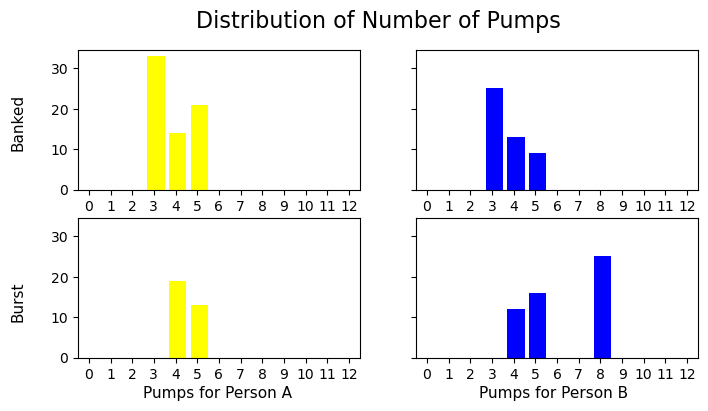

In [3]:
experiment = np.random.permutation(np.concatenate((np.repeat(4, 50), np.repeat(8, 50))))
person_A = np.random.permutation(np.concatenate((np.repeat(3, 33), np.repeat(4, 33), np.repeat(5, 34))))
person_B = np.random.permutation(np.concatenate((np.repeat(3, 25), np.repeat(4, 25), np.repeat(5, 25), np.repeat(8, 25))))
df = pd.DataFrame(columns=["experiment", "person_A", "person_B"])
df["experiment"] = experiment
df["person_A"] = person_A
df["person_B"] = person_B
df["burst_A"] = df.apply(lambda x: x["person_A"] >= x["experiment"], axis=1)
df["burst_B"] = df.apply(lambda x: x["person_B"] >= x["experiment"], axis=1)

plot_banked_burst(df)

Alternatives to adjusted score:
- automatic BART: indicate n_pump in the beginning of the trial, but this is fundamentally different ito. cognitive processes: e.g. one decision vs. multiple decisions
- use trials with limitless pumps: leads to large variation
- avoid counting pumps: use number of explosions

Offered alternative: use **censoring**


# Censoring

- censored data: external constraints prevent the true value of an observation from being fully known
- note the difference:
    - censoring involves limitations in the measurement of true values
    - truncation involves limits on the values themselves

observed number of pumps is right censored (e.g. it is censored only if the value was to be greater than the observation)

**goal**: provide a cognitive process model that uses censoring to measure the distribution of intended pumps
**assumptions**:
- Gaussian distribution of the underlying distribution of intentions, truncated to be non-negative
- where mean is the **risk propensity**
- and the variability is the **behavioral consistency**

## Censoring vs Truncation

Below we plot several distributions to illustrate the difference:
$$
\begin{align*}
y_t &\sim \text{Gaussian}(1, 1) \tag{1}
\\
y_t' &\sim Gaussian_+(\rho_{p}, \beta_{p}) \tag{2}
\\
y_t &= \begin{cases} y_t' &\text{if} \quad y_t' <b_t \\ b_t &\text{if} \quad y_t' \geq b_t \end{cases} \tag{3}
\end{align*}
$$

1. Normal distribution 
2. The positive-normal (truncated) distribution
3. Censored distribution, based on (2), and a censoring value of $b_t$ (baloon burst)

where the model will incorporate:
- $y_{t}'$ is the *intended* number of pumps that participant $p$ intended to make on $t^{th}$ trial
- $\rho_{p}$: risk propensity
- $\beta_{p}$: behavioral consistency

Sampling: [cs_n, cs_tn, hn, n, truncated_normal]


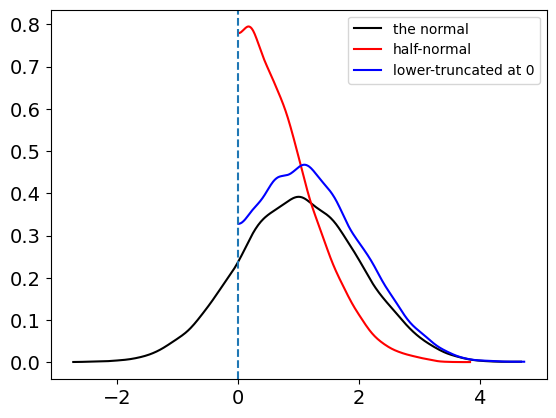

In [4]:
with pm.Model() as m:
    # define a Gaussian
    a_normal = pm.Normal("n", 1, 1)
    
    # the trucated normal, only the positive values 
    normal_dist = pm.Normal.dist(mu=1.0, sigma=1.0)
    truncated_normal = pm.Truncated("truncated_normal", normal_dist, lower=0)
    
    # the censored normal
    cs_normal = pm.Censored("cs_n", normal_dist, lower=0, upper=3)
    
    # the truncated and censored normal
    truncated_normal_dist = pm.Truncated.dist(normal_dist, lower=0)
    cs_truncated_normal = pm.Censored("cs_tn", truncated_normal_dist, lower=None, upper=3)

    # the halfnormal
    half_normal = pm.HalfNormal("hn", 1)

with m:
    idata = pm.sample_prior_predictive(samples=10000)

az.plot_dist(idata.prior.stack(samples=("chain", "draw")).n, color='k', label="the normal")
az.plot_dist(idata.prior.stack(samples=("chain", "draw")).hn, color='r', label="half-normal")
ax=az.plot_dist(idata.prior.stack(samples=("chain", "draw")).truncated_normal, color='b', label="lower-truncated at 0")
ax.axvline(x=0, linestyle="--");

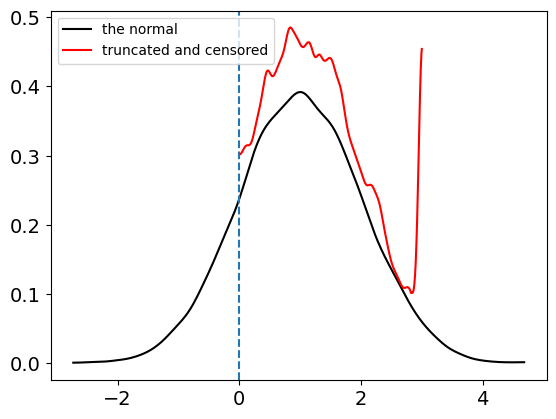

In [5]:
az.plot_dist(idata.prior.stack(samples=("chain", "draw")).n, color='k', label="the normal")
ax = az.plot_dist(idata.prior.stack(samples=("chain", "draw")).cs_tn, color='r', label="truncated and censored")
ax.axvline(x=0, linestyle="--");

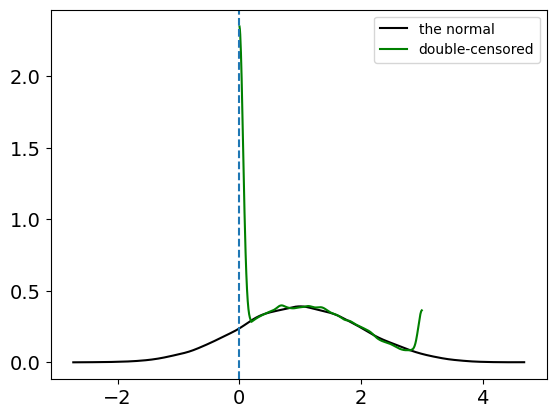

In [6]:
az.plot_dist(idata.prior.stack(samples=("chain", "draw")).n, color='k', label="the normal")
ax = az.plot_dist(idata.prior.stack(samples=("chain", "draw")).cs_n, color='g', label="double-censored")
ax.axvline(x=0, linestyle="--");

# The Model

Assumptions:
- on each trial the participants' intended number of pumps is sampled from a truncated Gaussian distribution with mean $\rho_p$ and standard deviation $\beta_p$ for participant $p$
- number of pumps = non-negative integer = truncated Gaussian rounded to the nearest whole number
- the intended number of pumps for participant $p$ on the trial $t$: $y'_t$
- $b_t$: the right censoring value, i.e. number of pumps it takes for the balloon to burst on trial $t$
- $\rho_i$ and $\beta_i$: priors for participant $i$
$$
\begin{align*}
y'_t &\sim \lfloor Gaussian_+(\rho_{p_t}, \beta_{p_t}) \rceil
\\
y_t &= \begin{cases} y_t' &\text{if} \quad y_t' <b_t \\ b_t &\text{if} \quad y_t' \geq b_t \end{cases}
\\
\rho_i &\sim Gaussian_+(0,100) 
\\
\beta_i &\sim Gaussian_+(0,100)

\end{align*}
$$

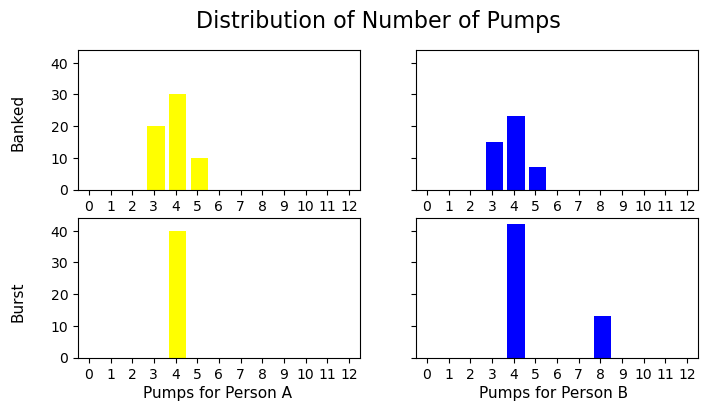

In [7]:
# load demo data
osf_folder = "../coon_osf_files"
demo_file = "BARTDemo.csv"
df0 = pd.read_csv(os.path.join(osf_folder, "data", demo_file))
df0["outcome"] = df0.apply(lambda x: x[" y"] >= x[" burst"], axis=1)
df0["trial"] = np.tile(np.arange(100), 2)

# make some adjustments for plotting
df1 = df0.pivot_table(columns="participant", index="trial")
df1 = df1.drop(columns=[(" burst", 1)])
df1.columns = [col if isinstance(col, str) else f"{col[0].strip()}_{col[1]}" for col in df1.columns]
df1 = df1.rename(columns={
    'burst_2': 'experiment',
    'y_1': 'person_A',
    'y_2': 'person_B',
    'outcome_1': 'burst_A',
    'outcome_2': 'burst_B'
})
df1 = df1.astype({'burst_A': bool, 'burst_B': bool})

# plot 
plot_banked_burst(df1)

In [8]:
df0[" y"] = df0[" y"].astype(float)
df0[" burst"] = df0[" burst"].astype(float)
df0["participant"] = df0["participant"] - 1

In [9]:
with pm.Model() as m_demo:
    rho = pm.LogNormal('rho', 0, 1., shape=2)
    beta = pm.Exponential('beta', 1., shape=2)
    
    # rho = pm.Normal('rho', 0, 1., shape=2)
    # beta = pm.Normal('beta', 0, 1., shape=2)


    intended = pm.Normal.dist(mu=rho[df0["participant"]], sigma=beta[df0["participant"]])

    pump = pm.Censored(
        "pump",
        intended,
        lower=None,
        upper=df0[" burst"],
        observed=df0[" y"],
    )


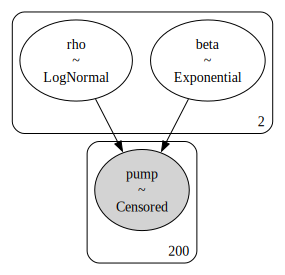

In [10]:
pm.model_to_graphviz(m_demo)

In [11]:
with m_demo:
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [12]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho[0],4.159,0.086,4.003,4.323,0.001,0.001,3861.0,3304.0,1.0
rho[1],5.623,0.290,5.118,6.206,0.005,0.003,3548.0,2939.0,1.0
beta[0],0.741,0.071,0.616,0.876,0.001,0.001,3944.0,3334.0,1.0
beta[1],2.214,0.242,1.781,2.674,0.005,0.003,3033.0,2878.0,1.0


In [13]:
idata_posterior = idata.posterior.stack(sample=("chain", "draw"))
idata_posterior.sel(rho_dim_0=1).rho

<xarray.DataArray 'rho' (sample: 4000)> Size: 32kB
array([6.37926428, 4.86090296, 4.95025056, ..., 5.29709514, 5.57508356,
       5.46926637])
Coordinates:
    rho_dim_0  int64 8B 1
  * sample     (sample) object 32kB MultiIndex
  * chain      (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  * draw       (sample) int64 32kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999

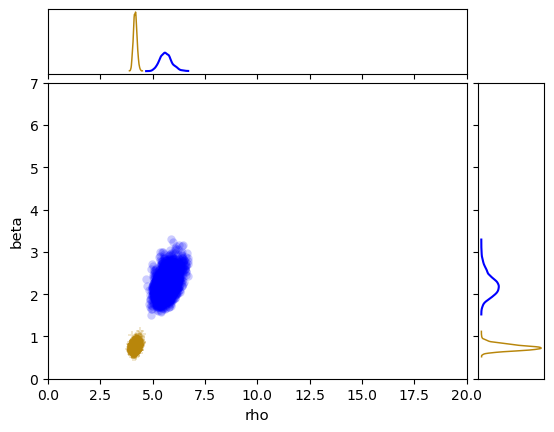

In [14]:
data = az.load_arviz_data("non_centered_eight")

ax = az.plot_pair(
    idata,
    marginals=True,
    group='posterior',
    var_names=["rho", "beta"],
    kind='scatter',
    textsize=10,
    scatter_kwargs={'marker': 'P', 'facecolors': 'darkgoldenrod', 'alpha': 0.2},
    marginal_kwargs={"color": "darkgoldenrod"},
    coords={"rho_dim_0": 0,
            "beta_dim_0": 0,}
)

for i in np.arange(len(ax)):
    ax[i][0].set_xlim([0, 20])
ax[1][0].set_ylim([0, 7])

az.plot_pair(
    idata,
    marginals=False,
    group='posterior',
    var_names=["rho", "beta"],
    kind='scatter',
    textsize=10,
    scatter_kwargs={'marker': 'o', 'facecolors': 'blue', 'alpha': 0.2 },
    coords={"rho_dim_0": 1,
            "beta_dim_0": 1,},
    ax=ax[1, 0]
)

az.plot_dist(idata_posterior.sel(beta_dim_0=1).beta, color='blue', rotated=True, ax=ax[1,1])
az.plot_dist(idata_posterior.sel(rho_dim_0=1).rho, color='blue', rotated=False, ax=ax[0,0])

plt.show()

## Model Posteriors

for person A
- inference is relatively certain
- consistently intending to make close to four pumps on every trial

for person B
- much more uncertain
- intending to make an average of around six pumps
- high variability across trials

In [15]:
print(
    "person A: \n",
    "- risk propensity 95%HDI: ", az.hdi(idata_posterior.sel(rho_dim_0=0).rho.values, hdi_prob=0.95), "\n",
    "- behavioral consistency 95%HDI: ", az.hdi(idata_posterior.sel(beta_dim_0=0).beta.values, hdi_prob=0.95), "\n",
    "person B: \n",
    "- risk propensity 95%HDI: ", az.hdi(idata_posterior.sel(rho_dim_0=1).rho.values, hdi_prob=0.95), "\n",
    "- behavioral consistency 95%HDI: ", az.hdi(idata_posterior.sel(beta_dim_0=1).beta.values, hdi_prob=0.95), "\n",
    )

person A: 
 - risk propensity 95%HDI:  [3.99088124 4.32305384] 
 - behavioral consistency 95%HDI:  [0.60688036 0.88042285] 
 person B: 
 - risk propensity 95%HDI:  [5.07322658 6.20975227] 
 - behavioral consistency 95%HDI:  [1.78110305 2.71326632] 



### Posterior Predictives

In [16]:
posterior = idata.posterior
n_samples = posterior.sizes["chain"] * posterior.sizes["draw"]

# stack chain and draw to get flat samples
posterior_stacked = posterior.stack(sample=("chain", "draw"))

rho_samples = posterior_stacked["rho"].values
beta_samples = posterior_stacked["beta"].values

pp_A = np.round(np.random.normal(rho_samples[0,:], beta_samples[0, :]))
pp_B = np.round(np.random.normal(rho_samples[1,:], beta_samples[1, :]))

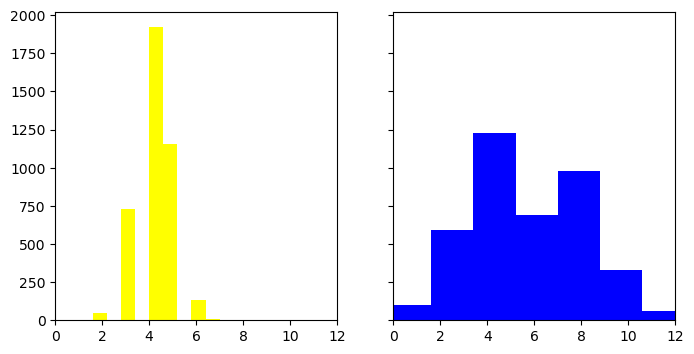

In [17]:

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8,4))
c = ["yellow", "blue"]
axs[0].hist(pp_A, color=c[0])
axs[1].hist(pp_B, color=c[1])
axs[0].set_xlim([0, 12])
axs[1].set_xlim([0, 12]);